## Facultative anaerobes

Some organisms like lactic acid bacteria and yeasts are able to survive under aerobic and anaerobic conditions. This implies that energy (ATP) can be generated form respiration (oxidative phosphorylation) or substrate level phosphorylation (ATP generation from the fermentative pathways). In the previous [section](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/6%20Modeling%20stoichiometry%20variations/Oxygen%20starvation%20in%20batch%20fermenters.ipynb) we have seen how growth is slow down by an oxygen limitation. In the example in this section the microbe has an alternative pathway to generate ATP (anaerobic) that can be used when the oxygen supply is limited. The microbe will thus attempt to maintain its growth rate ($\mu$ factory) by generating the ATP without using oxygen. More detail is provided in the video.

[Video: Lecture 17 Microbe suffocation](https://youtu.be/G5BEYfLWuBY)

<img src="saccie.jpg" width="450" />


_Pichia stipitis_ is a prime example of a facultative anaerobe. The metabolism of the organism is given by the following:

<img src="etresp.png" width="650" />


Note that the respiration flux is given as $r_2$.

The following physiological parameters will be used:


|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$| $(P/O)$ $\qquad \qquad$
|----|-|-|-|-
|$\frac{cmol\,CO_2}{cmol \, X}$|$\frac{mol \, ATP}{Cmol \, X}$|$\frac{1}{h}$|$\frac{mol \, ATP}{cmol\,X\cdot h}$|$\frac{mol\,ATP}{mol\, O}$
|0.05|2.3|0.25|0.15|1.5




In [3]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline
alpha, gamma, PO =0.05, 2.3, 1.5
mumax, thetamax= 0.25, 0.15

Let's assume the standard biomass formula of $CH_{1.8}O_{0.5}N_{0.2}$.

The growth and maintenance functions are given below:

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1-\frac{C_e}{C_e^*} \right]$$

$$\theta=\theta_{max}\left[\frac{Cs}{Km+Cs}\right]$$

Parameters are defined in the cell below:

In [4]:
Cemax, Km= 2.5, 0.01

The 'hidden' flux model is given as [Tut11_matrix.xlxs](https://github.com/willienicol/Biochemical-engineering-notes/blob/master/Tutorials/Tut11_matrix.xlsx). There is 4 fundamental equations for the 7 fluxes. The fourth equation (fourth row) represents the ATP balance and can be set equal to $\theta$

a) For questions a-f we will only work with the flux model (no integration required). Set up your own flux model and test against the supplied flux model. For anaerobic operation ($r_6=r_2=0$) the following should be obtained with $\theta_{max}$ and $\mu_{max} $ values:

$$Gluc \to 0.1026X + 0.594Et +0Glyc + 0.302CO_2 $$

For full aerobic operation ($r_4=r_5=0$) the following should be obtained with $\theta_{max}$ and $\mu_{max} $ values:

$$Gluc + 0.43 O_2 \to 0.543X +0.456 CO_2$$

(Answers were given on cmol basis while nitrogen source was ignored)

In [5]:
#specifications r2=r6=0
def response_anae(C):
    Cx, Cs, Ce, Cg, Cco2, Cdhap = C[0], C[1], C[2], C[3], C[4], C[5]
    
    S = numpy.matrix(pandas.read_excel('Tut11_matrix.xlsx'))
    S1 = numpy.vstack([S,[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,0,0,0,1]])
    K = numpy.matrix([0,0,0, thetamax, mumax, 0, 0]).T
    r = numpy.linalg.solve(S1,K)
    
    return [r[1,0],      #X
            -r[0,0],     #Glucose
            r[5,0],      #Ethanol
            r[4,0],      #Gly
            r[2,0],      #respiration
            r[3,0]]      #DHAP(5)

In [6]:
Cxo = 0
Cso = 1
Co = [Cxo, Cso, 0, 0, 0, 0]

rates_anae = response_anae(Co)

rx = rates_anae[0]
rs = -rates_anae[1]
re = rates_anae[2]
rg = rates_anae[3]
rdhap = rates_anae[5]
rco2 = (1/3)*rdhap + alpha*rx + rates_anae[4]

Yanae = [('Ysx=',rx/rs),
        ('Yss=',rs/rs),
        ('Yse=',re/rs),
        ('Ysg=',rg/rs),
        ('Ysco2=', rco2/rs)]

Yanae

[('Ysx=', 0.10256410256410249),
 ('Yss=', 1.0),
 ('Yse=', 0.5948717948717945),
 ('Ysg=', 2.4248002872994483e-16),
 ('Ysco2=', 0.3025641025641025)]

The glycerol result is to the power of -16, so considered 0. Results verify given yield coefficients.

In [7]:
#specification: r4=r5=0
def response_aero(C):
    Cx, Cs, Ce, Co, Cco2, Cdhap = C[0], C[1], C[2], C[3], C[4], C[5]
    
    S = numpy.matrix(pandas.read_excel('Tut11_matrix.xlsx'))
    S1 = numpy.vstack([S,[0,1,0,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0]])
    K = numpy.matrix([0,0,0, thetamax, mumax, 0, 0]).T
    r = numpy.linalg.solve(S1,K)
    
    return [r[1,0],      #X
            -r[0,0],     #glucose
            r[5,0],      #Ethanol
            r[6,0],      #oxygen
            r[2,0],      #respiration
            r[3,0]]      #DHAP 

In [8]:
Cxo = 0
Cso = 1
Co = [Cxo, Cso, 0, 0, 0, 0]

rates_aero = response_aero(Co)

rxaer = rates_aero[0]
rsaer = -rates_aero[1]
roaer = rates_aero[3]
rdhapaer = rates_aero[5]
rco2aer = (1/3)*rdhapaer + alpha*rx + rates_aero[4]

Yaer = [('Ysx=',rxaer/rsaer),
        ('Yss=',rsaer/rsaer),
        ('Yso=',roaer/rsaer),
        ('Ysdhap=',rdhapaer/rsaer), #check to ensure it's 0
        ('Ysco2=', rco2aer/rsaer)]

Yaer

[('Ysx=', 0.5432098765432098),
 ('Yss=', 1.0),
 ('Yso=', 0.42962962962962953),
 ('Ysdhap=', -8.198699131207691e-17),
 ('Ysco2=', 0.45679012345679)]

All values verify given coefficients for anaerobic respiration

b) For the answers above, what is $\frac{-r_S^{aerobic}}{-r_S^{anaerobic}}$ and why?  [$0.189$]

In [9]:
Ratio_aer_anae = -rsaer/-rs
Ratio_aer_anae

0.18881118881118866

The aerobic pull on glucose is higher. More energy required to produce ATP with the availability of oxygen.

c) Determine $r_O$ for aerobic operation. [$0.198 \frac{mol}{cmol \, X \cdot h}$]

In [17]:
print(roaer,'mol/cmolx.h')

0.19772727272727272 mol/cmolx.h


d) Specify $r_O =0.12 \frac{mol}{cmol \, X \cdot h}$, assume zero glycerol formation while still using maximum energy generation ($\theta_{max}$ and $\mu_{max} $). Make sure you obtain the following:

$$Gluc + 0.097 O_2 \to 0.202X + 0.46Et +0Glyc + 0.337CO_2 $$

We'll refer to the stoichiometry above as **partially aerobic.**

The anaerobic pathway produces no glycerol (a) so the glycerol assumption is valid. Note that $r_O$ is smaller than the answer in (c). Specify the answer in (c) in the formulation and note that zero ethanol forms (without an ethanol specification).

The partial aerobic stoichiometry represents a combination of respiration and ethanol formation. Ethanol was formed since the cell based oxygen supply ($r_O$) was not enough to obtain all the required ATP from respiration. 

Note that the total ATP requirement for all the scenarios above (aerobic, anaerobic and partially aerobic) is  $\theta_{max}+\gamma\mu_{max}$ 








In [25]:
#spec: r6=0.12, r4=0 and using mumax and thetamax

def resp_part_aero(C):
    Cx, Cs, Ce, Co, Cco2, Cdhap = C[0], C[1], C[2], C[3], C[4], C[5]
    
    S = numpy.matrix(pandas.read_excel('Tut11_matrix.xlsx'))
    S1 = numpy.vstack([S,[0,1,0,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]])
    K = numpy.matrix([0,0,0, thetamax, mumax, 0, 0.12]).T
    r = numpy.linalg.solve(S1,K)
    
    return [r[1,0],      #X
            -r[0,0],     #Glucose
            -r[6,0],     #Oxygen
            r[5,0],      #Ethanol
            r[4,0],      #Glycerol
            r[2,0],      #respiration
            r[3,0]]      #DHAP 

In [23]:
Cxo = 0
Cso = 1
Co = [Cxo, Cso, 0, 0, 0, 0]

rates_pa = resp_part_aero(Co)

rxpa = rates_pa[0]
rspa = -rates_pa[1]
ropa = -rates_pa[2]
retpa = rates_pa[3]
rgpa = rates_pa[4]
rco2pa = rates_pa[5]
rdhappa = rates_pa[6]
rco2pa = (1/3)*rdhappa + alpha*rxpa + rates_pa[5]

Yapa = [['Ysx=',  rxpa/rspa],
        ['Yss=',  rspa/rspa],
        ['Yso=',  ropa/rspa],
        ['Yse=',  retpa/rspa],
        ['Ysg=',  rgpa/rspa],
        ['Ysco2=', rco2pa/rspa]]

Yapa

[['Ysx=', 0.202020202020202],
 ['Yss=', 1.0],
 ['Yso=', 0.09696969696969694],
 ['Yse=', 0.46060606060606063],
 ['Ysg=', 0.0],
 ['Ysco2=', 0.33737373737373727]]

e) What fraction of ATP in (d) was generated via ethanol production? [39.3%]

In [32]:
ATP_tot = thetamax + gamma*mumax 
ATP_Et = (1/2)*retpa
percentage = (ATP_Et/ATP_tot)*100
print(percentage,'%')
#ATP_Et
#retpa

39.31034482758622 %


Explaining ATP in stream r3 (ethanol stream):
1ATP in stream r3 = 2/3*ATP in stream r5
since there is 1/3 net ATP in stream r3, this can be translated as:
ATP in stream r3 = (3/1)*(2/3)ATP in stream r5 

Note that we are not integrating yet! We do however understand that partial aerobic conditions will result in the accumulation of ethanol in the fermenter. We can see from the the growth function $\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1-\frac{C_e}{C_e^*} \right]$ that ethanol will reduce the value of $\mu$. Consider this when answering the next question.

f) **Without integrating**, determine the concentration of ethanol in the fermenter where growth will terminate. Note that we assume that $r_O=0.12$ like in (d) at all times. [$1.24 \frac{cmol}{L}$]

Answer notes: we're just considering $\mu=\mu_{max} \left[1-\frac{C_e}{C_e^*} \right]$

In [38]:
S1 = numpy.matrix(pandas.read_excel('Tut11_matrix.xlsx'))
S2 = numpy.vstack([S1,[0,0,0,0,0,1,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]])
K = numpy.matrix([0,0,0, thetamax, 0, 0, 0.12]).T
r = numpy.linalg.solve(S2,K)

mu1=r[1] 
Ce = ((mu1/mumax) - 1)*Cemax
print(-Ce,'cmol/L')

#Cemax

[[1.23913043]] cmol/L


g) You are now going to construct your own response function. Like in tutorial 10 you will calculate a maximum volumetric transfer rate of oxygen ($r_{O_2}^{mt_{max}}$) and use this value to determine where the response function switch from aerobic to partial aerobic. Normal aerobic respiration (with a constant $r_O$) will occur if the following condition is obeyed:

$$r_{O}^{mt_{max}}>r_{O}\cdot C_X$$

As soon as this condition is violated, the specifications in the stoichiometric matrix need to change. An oxygen specification similar to tutorial 10 will be used. The only difference is that $\mu$ will still be specified (note that ethanol in the fermenter will reduce $\mu$) while ethanol formation will be allowed for.

Use the following values for your integration:


In [39]:
kla=180 #1/h
Co_sat= 7/1000/32  #mol O2 per liter
Cxo=0.005  #cmol/L
Cso=7  #cmol/L

In [40]:
def response_fun(C):
    
    Cx, Cs, Ce, Co, Cco2 = C[0], C[1], C[2], C[3], C[4]      
    mu=mumax*Cs/(Km+Cs)*(1-Ce/Cemax)
    theta=thetamax*Cs/(Km+Cs)
    
    ro_mt=kla*Co_sat
    
    Sbase = numpy.matrix(pandas.read_excel('Tut11_matrix.xlsx'))
    S1 = numpy.vstack([Sbase,[0,1,0,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0]])
    K = numpy.matrix([0,0,0, theta, mu, 0, 0]).T
    r = numpy.linalg.solve(S1,K)        
        
    if ro_mt > r[6,0]*Cx:    #no oxygen limitation
        
        return [r[1,0],      #Biomass
               -r[0,0],      #Glucose
                r[5,0],      #Ethanol
                r[6,0],      #Oxygen
                r[2,0],      #respiration
                r[3,0]]      #DHAP                                                 
                
    else:
        
        S2 = numpy.vstack([Sbase,[0,1,0,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]])
        C2= numpy.matrix([[0,0,0,theta,mu,0,ro_mt/Cx]]).T   # Note the ro specification!!
        r2 = numpy.linalg.solve(S2,C2)                 # rates for regime where oxygen limitation exist
        
        
        return [r2[1,0],    #Biomass
               -r2[0,0],    #Glucose
                r2[5,0],    #Ethanol
                r2[6,0],    #Oxygen
                r2[2,0],    #respiration
                r2[3,0]]    #Dhap 

In [41]:
def ferm_eq(C,t):
    Cx, Cs, Ce, Co, Cco2 = C[0], C[1], C[2], C[3], C[4]
    r=response_fun([Cx, Cs, Ce, Co, Cco2])     
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx,
            r[3]*Cx,
            r[4]*Cx]   

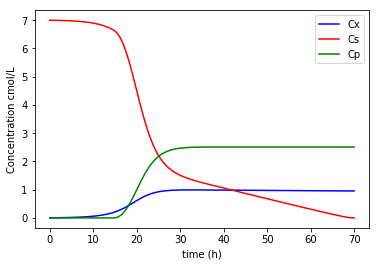

In [43]:
Co=[Cxo, Cso,0, 0, 0]                     # [Cxo, Cso, Ce, Co, Cco2] in cmol/L
tmax=70                                  # Integrate for 120 hours  
tspan=numpy.linspace(0,tmax,121)           # define the timespan of the integration
Ci = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

Cx, Cs, Cp, Co, Cco2 = Ci.T

plt.figure(1)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='red', label='Cs')
plt.plot(tspan, Cp, color='green', label='Cp')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Your answer should look something like this:

<img src="tut11_ans.png" width="650" />

Play around with the rates to examine the different phases of the fermentation.


[Back to all tutorials](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/Tutorials/All%20tutorials.ipynb)